In [90]:
import cv2
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Path to the dataset

In [80]:
dataset_path = '/kaggle/input/att-database-of-faces'

# Read images

X shape: (400, 10304)
y shape: (400,)


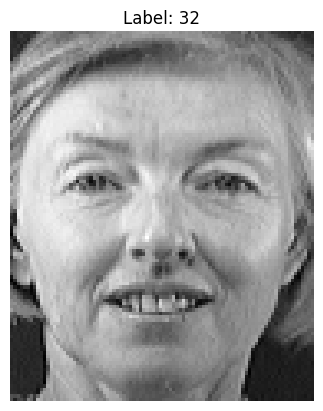

In [81]:
images = []
labels = []

for person_dir in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person_dir)
    if os.path.isdir(person_path):
        label = int(person_dir[1:])
        for image_name in os.listdir(person_path):
            image_path = os.path.join(person_path, image_name)
            # Grayscale images of shape (112, 92)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            # Flatten the image to be has shape (112 * 92 -> 10304, )
            img_flattened = img.flatten()
            images.append(img_flattened)
            labels.append(label)

# Convert lists to numpy arrays
X = np.array(images)
y = np.array(labels)

# Get the shape of the dataset and its label
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Show one image
plt.imshow(X[0].reshape(112, 92), cmap='gray')
plt.title(f"Label: {y[0]}")
plt.axis('off')
plt.show()

# Split data into training and testing data 

In [87]:
X_train = []
y_train = []
X_test = []
y_test = []

m,_ = X.shape
for i in range(0, m-1, 2):
    X_train.append(X[i])
    y_train.append(y[i])
    X_test.append(X[i+1])
    y_test.append(y[i+1])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Get the shape of the splited dataset and its label
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (200, 10304)
y_train shape: (200,)
X_test shape: (200, 10304)
y_test shape: (200,)


# K-means

In [99]:
class KMeans:
    def __init__(self, n_clusters=3, max_iters=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol

    def fit(self, X, y=None):
        self.y_true = y  # Store true labels if provided
        
        # Initialize centroids randomly from the dataset
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
        for i in range(self.max_iters):
            # Assign each point to the nearest centroid
            self.labels = self._assign_cluster_labels(X, y)
            
            # Calculate new centroids
            new_centroids = self._calculate_centroids(X)
            
            # Check for convergence (if the centroids don't change much)
            if np.all(np.abs(new_centroids - self.centroids) < self.tol):
                break
                
            self.centroids = new_centroids

    def _assign_labels(self, X):
        # Compute distance from each point to each centroid
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        # Assign labels based on closest centroid
        return np.argmin(distances, axis=1)

    def _assign_cluster_labels(self, X, y=None):
        # Compute distances and find the nearest cluster
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        cluster_indices = np.argmin(distances, axis=1)

        if y is None:
            return cluster_indices
        else:
            # Assign majority label within each cluster
            labels = np.zeros_like(cluster_indices)
            for cluster in range(self.n_clusters):
                indices = np.where(cluster_indices == cluster)[0]
                if len(indices) > 0:
                    majority_label = Counter(y[indices]).most_common(1)[0][0]
                    labels[indices] = majority_label
            return labels

    def _calculate_centroids(self, X):
        # Calculate the mean of the points assigned to each centroid
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
            points = X[self.labels == i]
            if len(points) > 0:
                centroids[i] = points.mean(axis=0)
        return centroids

    def predict(self, X):
        return self._assign_cluster_labels(X)

# Training step

In [102]:
alphas = [0.8, 0.85, 0.9, 0.95]
clusters = [20, 40, 60]

# Standardize the data (important for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

for alpha in alphas:
    # Apply PCA with desired explained variance
    pca = PCA(n_components=alpha)
    X_train_pca = pca.fit_transform(X_train_scaled)
    print(f"At alpha={alpha}")
    for k in clusters:
        # Instantiate the KMeans object
        kmeans = KMeans(n_clusters=k)

        # Fit the model
        kmeans.fit(X_train_pca, y_train)
        
        # Print the centroids
        print(f"At k={k} clusters_labels:\nf{kmeans.labels}")
    print("="*100)

At alpha=0.8
At k=20 clusters_labels:
f[18 39 39 18 18 39 39 39 39 39 39 39 39 18 39 39 39 39 39 39 18 18 18 18
 18 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 18 18 18 18 39 39 39 39
 39 39 39 39 39 39 39 18 18 18 18 18 39 39 39 39 39 39 39 39 39 39 39 18
 39 39 39 18 18 18 18 18 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 39 18 18 18 18 18 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 18 18 18 18
 18 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 18 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 18 18 39 39]
At k=40 clusters_labels:
f[32  2 15 32 32 22 29 29 22 22 26 26 26  5 26 20 38 20 20 20  5 18 18 18
 18 25 25 25 25  5 24 24 24 24 24 14 14 14 14 14 18 35  5 18  5 19 15 15
 19 19 33 21 21 33 33  2 18 35 32 18 11 11 11 11 11 34 31 31 34 34 35 35
 25 25 25 35 18 18  5 35 19 15 19 19 19 29 29 15 29 30 26 26 37 37 37 10
 10 10 10 10  8  8  8  8  8  5  5